In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import dateutil.parser
import numpy as np
import scipy.stats as st
import seaborn as sns

from matplotlib.lines import Line2D
from tqdm import tqdm
from datetime import timedelta, datetime
from sklearn.decomposition import NMF

In [84]:
tqdm.pandas()

In [85]:
billboard_hot_100 = pd.read_csv("billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)
billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year
billboard_hot_100 = billboard_hot_100[(billboard_hot_100["year"] > 1958) & (billboard_hot_100["year"] < 2023)]
billboard_hot_100.head()

,Unnamed: 0,first_day_of_the_week,artist,song_name,position,last_week_position,peak_position,weeks_on_chart,songwriters,producers,promotion_label,year
1611,1611,1959-01-12,The Chipmunks With David Seville,The Chipmunk Song,1,1.0,1,7,Not Listed,Not Listed,Liberty,1959
1615,1615,1959-01-05,The Chipmunks With David Seville,The Chipmunk Song,1,1.0,1,6,Not Listed,Not Listed,Liberty,1959
1628,1628,1959-01-12,The Platters,Smoke Gets In Your Eyes,2,2.0,2,9,"O.Harbach, J.Kern",Not Listed,Mercury,1959
1629,1629,1959-01-12,Connie Francis,My Happiness,3,6.0,3,6,"B.Bergantine, B.Peterson",Not Listed,MGM,1959
1630,1630,1959-01-12,Billy Grammer,Gotta Travel On,4,9.0,4,8,"P.Clayton, L.Ehrlich, R.Gilbert, L.Hays, F.Hel...",Not Listed,Monument,1959


In [86]:
plt.rcParams.update({'font.size': 15})

In [87]:
billboard_hot_100["artist_song"] = billboard_hot_100["artist"] + " - " +\
    billboard_hot_100["song_name"]
billboard_hot_100["top_position"] = billboard_hot_100.groupby("artist_song")["position"].transform("min")

In [6]:
# https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
def moving_average(x, w):
    return np.convolve(x, np.ones(w) / w, 'valid')

In [7]:
decades_data = {}

## Rank turnover

In [8]:
# number of songs ever seen until time t
def number_of_songs_seen(df, t):
    return len(df[df["first_day_of_the_week"] <= t]["artist_song"].unique())/100

In [9]:
number_of_songs_ever_seen = []

for decade in tqdm(range(1960, 2020, 10)):
    decades_data[decade] = {}
    songs_from_decade = billboard_hot_100[(billboard_hot_100["year"] >= decade) & (billboard_hot_100["year"] < decade + 10)]
    for l, first_day_of_the_week in tqdm(enumerate(songs_from_decade["first_day_of_the_week"].sort_values().unique())):
        number_of_songs_ever_seen.append(number_of_songs_seen(songs_from_decade, first_day_of_the_week))

    T_size = len(songs_from_decade["first_day_of_the_week"].sort_values().unique())
    mean_turnover = (number_of_songs_ever_seen[len(number_of_songs_ever_seen) - 1] - number_of_songs_ever_seen[0]) / (T_size - 1)
    decades_data[decade]["o"] = mean_turnover
    print(f"Mean turnover rate for {decade}s: " + str(mean_turnover))

522it [00:04, 120.25it/s]00<?, ?it/s]
 17%|█▋        | 1/6 [00:04<00:22,  4.40s/it]

Mean turnover rate for 1960s: 0.13174664107485604


522it [00:04, 119.98it/s]
 33%|███▎      | 2/6 [00:08<00:17,  4.39s/it]

Mean turnover rate for 1970s: 0.10166986564299424


521it [00:04, 121.93it/s]
 50%|█████     | 3/6 [00:13<00:13,  4.35s/it]

Mean turnover rate for 1980s: 0.07911538461538462


522it [00:04, 129.39it/s]
 67%|██████▋   | 4/6 [00:17<00:08,  4.23s/it]

Mean turnover rate for 1990s: 0.06587332053742802


522it [00:03, 131.12it/s]
 83%|████████▎ | 5/6 [00:21<00:04,  4.16s/it]

Mean turnover rate for 2000s: 0.06562380038387715


522it [00:04, 126.19it/s]
100%|██████████| 6/6 [00:25<00:00,  4.22s/it]

Mean turnover rate for 2010s: 0.08591170825335892


## Rank flux

In [10]:
# probabilities that song enter or leaves the chart at time t
def song_enter_leave_probabilities(df, t):
    songs_previous_week = df[df["first_day_of_the_week"] == (pd.to_datetime(t) - timedelta(weeks=1))]["artist_song"].unique()
    songs_now = df[df["first_day_of_the_week"] == t]["artist_song"].unique()
    songs_entered = list(set(songs_now) - set(songs_previous_week))
    return len(songs_entered)/100

In [11]:
enter_leave_porbabilities = []
for decade in tqdm(range(1960, 2020, 10)):
    songs_from_decade = billboard_hot_100[(billboard_hot_100["year"] >= decade) & (billboard_hot_100["year"] < decade + 10)]
    for first_day_of_the_week in tqdm(songs_from_decade["first_day_of_the_week"].sort_values().unique()):
        enter_leave_porbabilities.append(song_enter_leave_probabilities(songs_from_decade, first_day_of_the_week))

    mean_flux = np.mean(enter_leave_porbabilities)
    decades_data[decade]["F"] = mean_flux
    print(f"Mean flux for {decade}s: " + str(mean_flux))

 17%|█▋        | 1/6 [00:00<00:04,  1.06it/s]

Mean flux for 1960s: 0.14028735632183906


 33%|███▎      | 2/6 [00:01<00:03,  1.07it/s]

Mean flux for 1970s: 0.12289272030651342


 50%|█████     | 3/6 [00:02<00:02,  1.08it/s]

Mean flux for 1980s: 0.10907987220447285


 67%|██████▋   | 4/6 [00:03<00:01,  1.11it/s]

Mean flux for 1990s: 0.09908001916626737


 83%|████████▎ | 5/6 [00:04<00:00,  1.12it/s]

Mean flux for 2000s: 0.09438865465695669


100%|██████████| 6/6 [00:05<00:00,  1.10it/s]

Mean flux for 2010s: 0.09689556052379432


In [12]:
for decade in tqdm(range(1960, 2020, 10)):
    songs_from_decade = billboard_hot_100[(billboard_hot_100["year"] >= decade) & (billboard_hot_100["year"] < decade + 10)]
    p0 = 100 / songs_from_decade["artist_song"].nunique()
    decades_data[decade]["p0"] = p0
    print(f"p0 for {decade}s: " + str(100 / songs_from_decade["artist_song"].nunique()))

 67%|██████▋   | 4/6 [00:00<00:00, 36.59it/s]

p0 for 1960s: 0.014359563469270534
p0 for 1970s: 0.01852881230313137
p0 for 1980s: 0.023730422401518746
p0 for 1990s: 0.028312570781426953
p0 for 2000s: 0.02841716396703609


100%|██████████| 6/6 [00:00<00:00, 36.32it/s]

p0 for 2010s: 0.021853146853146852


## Displacement probability

In [15]:
import pickle

# with open('displacement_prob_data.pkl', 'wb') as f:
#     pickle.dump(data, f)

In [16]:
with open('displacement_prob_data.pkl', 'rb') as f:
    data = pickle.load(f)

### t=1

In [17]:
def probability(df, initial_rank, new_pos, t):
    init_rank_df = df[(pd.to_datetime(t) + timedelta(weeks=-1)).to_datetime64()][initial_rank]
    time_after_df = df[t][new_pos]
    new_pos_after_t = set(init_rank_df).intersection(set(time_after_df))
    return len(new_pos_after_t) / len(init_rank_df)

In [18]:
decades_data[1960]["v"] = 0.0114
decades_data[1970]["v"] = 0.0076
decades_data[1980]["v"] = 0.0054
decades_data[1990]["v"] = 0.0046
decades_data[2000]["v"] = 0.005
decades_data[2010]["v"] = 0.0098

for decade in tqdm(range(1960, 2020, 10)):
    decades_data[decade]["tau"] = decades_data[decade]["v"] * (decades_data[decade]["o"] - decades_data[decade]["v"]) / (decades_data[decade]["v"] - decades_data[decade]["p0"] * decades_data[decade]["o"])


100%|██████████| 6/6 [00:00<?, ?it/s]


4it [00:39,  9.92s/it]00:00<?, ?it/s]
4it [00:33,  8.46s/it]00:39<03:18, 39.71s/it]
4it [00:27,  6.76s/it]01:13<02:25, 36.29s/it]
4it [00:18,  4.55s/it]01:40<01:36, 32.10s/it]
4it [00:18,  4.60s/it]01:58<00:53, 26.62s/it]
4it [00:24,  6.10s/it]02:17<00:23, 23.68s/it]
100%|██████████| 6/6 [02:41<00:00, 26.98s/it]


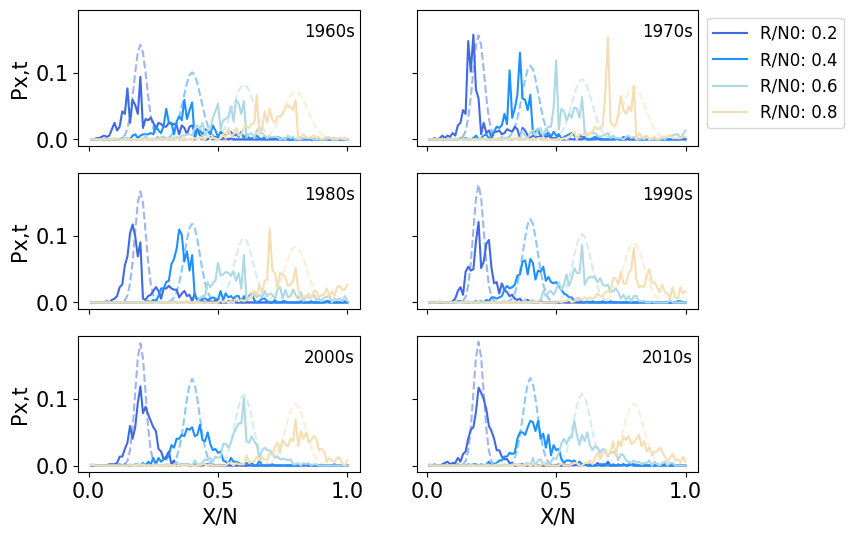

In [19]:
import math
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)

row_i, col_i = 0, 0
N0 = 100

#model
for decade in tqdm(range(1960, 2020, 10)):
    songs_from_decade = billboard_hot_100[(billboard_hot_100["year"] >= decade) & (billboard_hot_100["year"] < decade + 10)]
    tau = decades_data[decade]["tau"]
    v = decades_data[decade]["v"]
    N = songs_from_decade["artist_song"].nunique()
    p0 = N0 / N
    initial_ranks = [20, 40, 60, 80]
    pxts = []
    dr = 1/N

    colors = ["royalblue", "dodgerblue", "lightblue", "wheat", "sandybrown", "chocolate"]

    for i, initial_rank in enumerate(initial_ranks):
        #https://github.com/iniguezg/Farranks/tree/9b661fb269b52a381bc47662d0f573bbdafe011c
        r = (initial_rank) * dr
        ptau, pnu = tau, v

        dr = 1 / float( N ) #rank increment
        p0 = N0 / float( N ) #ranking fraction

        x_vals = np.linspace( dr, p0, num=N0 ) #values of displaced rank

        levi_sea = dr * ( 1 - np.exp( -ptau ) )
        peak_sdev = np.sqrt( 2 * ptau * dr * r * (1 - r) )
        disp_theo = np.exp( -pnu ) * ( levi_sea + np.exp( -ptau ) * st.norm.pdf( x_vals, loc=r, scale=peak_sdev ) * dr )

        pxts.append(disp_theo)

    xplot = np.arange(1, 101) / 100
    for i, initial_rank in enumerate(initial_ranks):
        axes[row_i, col_i].plot(xplot, pxts[i], c=colors[i], linestyle="dashed", alpha=0.5)
    
    #data
    pxts_data = []
    all_t = songs_from_decade["first_day_of_the_week"].sort_values().unique()
    decade_data = {t:data[t] for t in all_t}
    for i, initial_rank in tqdm(enumerate(initial_ranks)):
        pxts_data.append([])
        for j, pos in enumerate(range(1, 101)):
            pxts_data[i].append([])
            for t in all_t[1:]:
                try:
                    Pxt = probability(decade_data, initial_rank, pos, t)
                    pxts_data[i][j].append(Pxt)
                except Exception as e:
                    continue
            pxts_data[i][j] = np.mean(pxts_data[i][j])

    for i, initial_rank in enumerate(initial_ranks):
        axes[row_i, col_i].plot(xplot, pxts_data[i], label=f"R/N0: {initial_rank/100}", c=colors[i])
    
    axes[row_i, col_i].text(0.8, 0.8, f"{decade}s", transform=axes[row_i, col_i].transAxes, fontsize=12)
    if (row_i == 0) and (col_i == 1):
        axes[row_i, col_i].legend(bbox_to_anchor=(1, 1), fontsize=12)

    if row_i == 2:
        axes[row_i, col_i].set_xlabel("X/N")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Px,t")

    col_i += 1
    if col_i == 2:
        row_i += 1
        col_i = 0

plt.savefig("figures/pxt_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()

### t=4

In [20]:
def probability_4(df, initial_rank, new_pos, t):
    init_rank_df = df[(pd.to_datetime(t) + timedelta(weeks=-4)).to_datetime64()][initial_rank]
    time_after_df = df[t][new_pos]
    new_pos_after_t = set(init_rank_df).intersection(set(time_after_df))
    return len(new_pos_after_t) / len(init_rank_df)

4it [00:17,  4.49s/it]00:00<?, ?it/s]
4it [00:17,  4.46s/it]00:17<01:29, 17.99s/it]
4it [00:17,  4.46s/it]00:35<01:11, 17.93s/it]
4it [00:30,  7.57s/it]00:53<00:53, 17.91s/it]
4it [00:30,  7.64s/it]01:24<00:45, 22.82s/it]
4it [00:29,  7.39s/it]01:54<00:25, 25.63s/it]
100%|██████████| 6/6 [02:24<00:00, 24.06s/it]


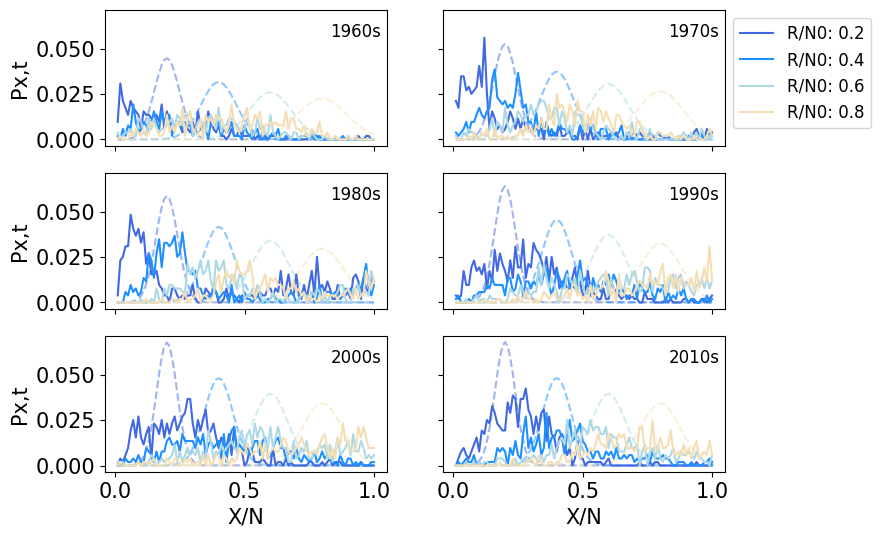

In [21]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)

row_i, col_i = 0, 0
N0 = 100
t_weeks = 4

#model
for decade in tqdm(range(1960, 2020, 10)):
    songs_from_decade = billboard_hot_100[(billboard_hot_100["year"] >= decade) & (billboard_hot_100["year"] < decade + 10)]
    tau = decades_data[decade]["tau"]
    v = decades_data[decade]["v"]
    N = songs_from_decade["artist_song"].nunique()
    p0 = N0 / N
    initial_ranks = [20, 40, 60, 80]
    pxts = []
    dr = 1/N

    colors = ["royalblue", "dodgerblue", "lightblue", "wheat", "sandybrown", "chocolate"]

    for i, initial_rank in enumerate(initial_ranks):
        #https://github.com/iniguezg/Farranks/tree/9b661fb269b52a381bc47662d0f573bbdafe011c
        r = (initial_rank) * dr
        ptau, pnu = tau, v

        dr = 1 / float( N ) #rank increment
        p0 = N0 / float( N ) #ranking fraction

        x_vals = np.linspace( dr, p0, num=N0 ) #values of displaced rank

        levi_sea = dr * ( 1 - np.exp( -ptau * t_weeks ) )
        peak_sdev = np.sqrt( 2 * ptau * dr * r * (1 - r) * t_weeks )
        disp_theo = np.exp( -pnu * t_weeks ) * ( levi_sea + np.exp( -ptau * t_weeks ) * st.norm.pdf( x_vals, loc=r, scale=peak_sdev ) * dr )

        pxts.append(disp_theo)

    xplot = np.arange(1, 101) / 100
    for i, initial_rank in enumerate(initial_ranks):
        axes[row_i, col_i].plot(xplot, pxts[i], c=colors[i], linestyle="dashed", alpha=0.5)
    
    #data
    pxts_data = []
    all_t = songs_from_decade["first_day_of_the_week"].sort_values().unique()
    decade_data = {t:data[t] for t in all_t}
    for i, initial_rank in tqdm(enumerate(initial_ranks)):
        pxts_data.append([])
        for j, pos in enumerate(range(1, 101)):
            pxts_data[i].append([])
            for t in all_t[4:]:
                try:
                    Pxt = probability_4(decade_data, initial_rank, pos, t)
                    pxts_data[i][j].append(Pxt)
                except Exception as e:
                    continue
            pxts_data[i][j] = np.mean(pxts_data[i][j])

    for i, initial_rank in enumerate(initial_ranks):
        axes[row_i, col_i].plot(xplot, pxts_data[i], label=f"R/N0: {initial_rank/100}", c=colors[i])
    
    axes[row_i, col_i].text(0.8, 0.8, f"{decade}s", transform=axes[row_i, col_i].transAxes, fontsize=12)
    if (row_i == 0) and (col_i == 1):
        axes[row_i, col_i].legend(bbox_to_anchor=(1, 1), fontsize=12)

    if row_i == 2:
        axes[row_i, col_i].set_xlabel("X/N")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Px,t")
    
    col_i += 1
    if col_i == 2:
        row_i += 1
        col_i = 0

plt.savefig("figures/pxt_4_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Average probability that an element changes rank by Levy walk, diffusion or is replaced

100%|██████████| 6/6 [00:00<00:00, 50.34it/s]


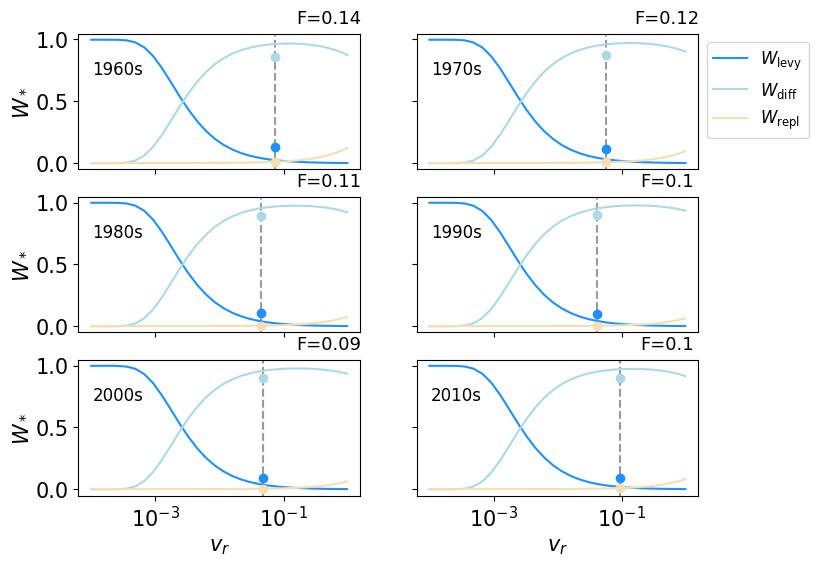

In [22]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)

row_i, col_i = 0, 0
colors = ["dodgerblue", "lightblue", "wheat", "sandybrown"]

for decade in tqdm(range(1960, 2020, 10)):
    open_deriv = decades_data[decade]["o"]
    p0 = decades_data[decade]["p0"]
    pnu = decades_data[decade]["v"]
    ptau = decades_data[decade]["tau"]
    mean_flux = decades_data[decade]["F"]

    pnu_resc = ( pnu - p0 * open_deriv ) / open_deriv
    ptau_resc = ptau / ( p0 * (1 - p0) * open_deriv )

    W_repl = 1 - np.exp( -pnu )
    W_diff = np.exp( -pnu ) * np.exp( -ptau )
    W_levy = np.exp( -pnu ) * ( 1 - np.exp( -ptau ) )

    pnu_resc_vals = np.logspace( -4, np.log10( 1 - p0 ), 30 ) #pick rescaled pnu as variable
    ptau_resc_vals = 1 / pnu_resc_vals #and slide over universal curve

    #model parameters
    pnu_vals = ( pnu_resc_vals + p0 ) * open_deriv
    ptau_vals = ptau_resc_vals * p0 * (1 - p0) * open_deriv

    #regime probabilities (with t=1)
    W_repl_vals = 1 - np.exp( -pnu_vals )
    W_diff_vals = np.exp( -pnu_vals ) * np.exp( -ptau_vals )
    W_levy_vals = np.exp( -pnu_vals ) * ( 1 - np.exp( -ptau_vals ) )

    #regime probabilities (in data)
    handle_data, = axes[row_i, col_i].semilogx( pnu_resc, W_levy, 'o', label=None, c=colors[0], zorder=2 )
    axes[row_i, col_i].semilogx( pnu_resc, W_diff, 'o', label=None, c=colors[1], zorder=2 )
    axes[row_i, col_i].semilogx( pnu_resc, W_repl, 'o', label=None, c=colors[2], zorder=2 )

    #(variable) regime probabilities
    handle_model, = axes[row_i, col_i].semilogx( pnu_resc_vals, W_levy_vals, label='$W_{\mathrm{levy}}$', c=colors[0], zorder=1 )
    axes[row_i, col_i].semilogx( pnu_resc_vals, W_diff_vals, label='$W_{\mathrm{diff}}$', c=colors[1], zorder=1 )
    axes[row_i, col_i].semilogx( pnu_resc_vals, W_repl_vals, label='$W_{\mathrm{repl}}$', c=colors[2], zorder=1 )
    axes[row_i, col_i].text(0.5, 1.1, f"F={round(mean_flux, 2)}", va='bottom', ha='center', fontsize=13)
    if (row_i == 0) and (col_i == 1):
        axes[row_i, col_i].legend(bbox_to_anchor=(1, 1), fontsize=12)

    axes[row_i, col_i].text(0.05, 0.7, f"{decade}s", transform=axes[row_i, col_i].transAxes, fontsize=12)

    #line at rescaled pnu
    handle_param = axes[row_i, col_i].axvline( pnu_resc, ls='--', c='0.6', label=None, zorder=0 )

    if row_i == 2:
        axes[row_i, col_i].set_xlabel(r'$v_r$')
    if col_i == 0:
        axes[row_i, col_i].set_ylabel(r'$W_*$')
    
    col_i += 1
    if col_i == 2:
        row_i += 1
        col_i = 0

plt.savefig("figures/levy_diff_repl_comparison.pdf", format="pdf", bbox_inches="tight")
plt.show()


## Number of songs proof

In [88]:
number_of_songs = billboard_hot_100[["artist", "song_name"]].drop_duplicates().groupby("artist")["song_name"].count().reset_index(name="song_count")
billboard_hot_100["number_of_songs"] = billboard_hot_100["artist"].progress_map(lambda artist: number_of_songs[number_of_songs["artist"] == artist]["song_count"].iloc[0])

100%|██████████| 333887/333887 [13:54<00:00, 400.23it/s]


In [24]:
numbers_of_songs = billboard_hot_100[["artist", "number_of_songs"]].drop_duplicates()
count_numbers_of_songs = numbers_of_songs["number_of_songs"].value_counts().sort_index()

In [25]:
numbers_of_songs[numbers_of_songs["number_of_songs"] > 30].sort_values("number_of_songs", ascending=False).to_csv("30_songs_artists.csv")

In [26]:
numbers_of_songs[numbers_of_songs["number_of_songs"] > 30].sort_values("number_of_songs", ascending=False).head(20)

,artist,number_of_songs
264990,Glee Cast,183
251137,Taylor Swift,163
264978,Drake,124
308081,YoungBoy Never Broke Again,75
27880,The Beatles,65
16545,Aretha Franklin,64
63031,Elton John,58
29835,The Rolling Stones,57
236351,Kanye West,56
30565,Stevie Wonder,54


In [27]:
top_3_artists = numbers_of_songs[numbers_of_songs["number_of_songs"] > 30].sort_values("number_of_songs", ascending=False).head(3)

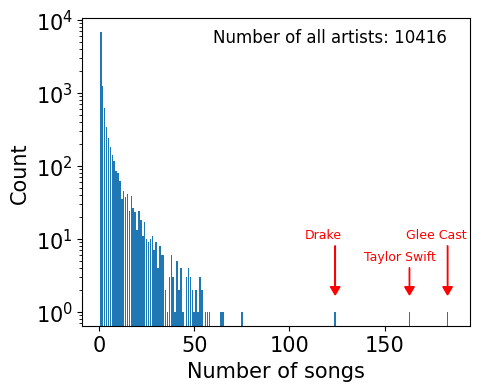

In [28]:
plt.figure(figsize=(5, 4))

plt.bar(count_numbers_of_songs.index, count_numbers_of_songs.values)
nartists = billboard_hot_100["artist"].nunique()
plt.text(60, 5000, f"Number of all artists: {nartists}", fontsize=12)

for i, (_, top_artist)in enumerate(top_3_artists.iterrows()):
    number_of_songs = top_artist["number_of_songs"]
    if i != 1:
        plt.arrow(number_of_songs, 8, 0, -5.8, width=0.2, head_width=5, head_length=0.5, color="red")
        plt.text(number_of_songs - 6, 14, top_artist["artist"], fontsize=9, color="red", va="top", ha="center")
    else:
        plt.arrow(number_of_songs, 4, 0, -1.8, width=0.2, head_width=5, head_length=0.5, color="red")
        plt.text(number_of_songs - 5, 7, top_artist["artist"], fontsize=9, color="red", va="top", ha="center")

plt.xlabel("Number of songs")
plt.ylabel("Count")
plt.yscale("log")
plt.savefig("figures/number_of_songs_per_artist.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Top 10

In [29]:
billboard_hot_100["top_10"] = billboard_hot_100["top_position"] <= 10
number_of_songs_10 = billboard_hot_100[["artist", "song_name", "top_10"]].drop_duplicates().groupby("artist")["top_10"].sum().reset_index(name="top_10_count")

In [30]:
count_numbers_of_songs = number_of_songs_10["top_10_count"].value_counts().sort_index()

In [31]:
number_of_songs_10[number_of_songs_10["top_10_count"] > 5].sort_values("top_10_count", ascending=False).to_csv("top_10_artists.csv")

In [32]:
number_of_songs_10[number_of_songs_10["top_10_count"] > 5].sort_values("top_10_count", ascending=False).head(20)

,artist,top_10_count
5702,Madonna,36
8424,Taylor Swift,35
8570,The Beatles,33
8210,Stevie Wonder,25
6074,Michael Jackson,24
2743,Elton John,23
9296,The Rolling Stones,23
5765,Mariah Carey,22
2528,Drake,22
10110,Whitney Houston,21


In [33]:
top_4_artists = number_of_songs_10[number_of_songs_10["top_10_count"] > 5].sort_values("top_10_count", ascending=False).head(4)

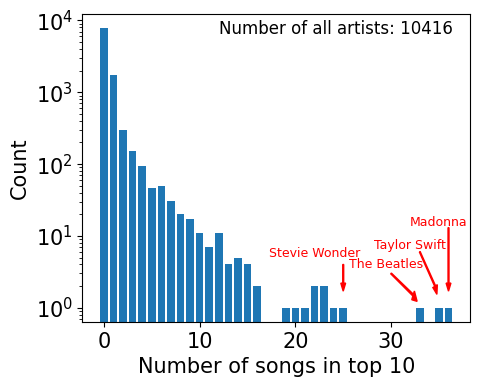

In [34]:
plt.figure(figsize=(5, 4))

plt.bar(count_numbers_of_songs.index, count_numbers_of_songs.values)
nartists = billboard_hot_100["artist"].nunique()
plt.text(12, 6500, f"Number of all artists: {nartists}", fontsize=12)

for i, (_, top_artist)in enumerate(top_4_artists.iterrows()):
    number_of_songs = top_artist["top_10_count"]
    if i == 0:
        plt.arrow(number_of_songs, 13, 0, -10.8, width=0.1, head_width=0.5, head_length=0.5, color="red")
        plt.text(number_of_songs - 1, 19, top_artist["artist"], fontsize=9, color="red", va="top", ha="center")
    elif i == 1:
        plt.arrow(number_of_songs - 2, 6, 1.6, -4, width=0.1, head_width=0.5, head_length=0.5, color="red")
        plt.text(number_of_songs - 3, 9, top_artist["artist"], fontsize=9, color="red", va="top", ha="center")
    elif i == 2:
        plt.arrow(number_of_songs - 3, 3, 2.3, -1.5, width=0.1, head_width=0.5, head_length=0.5, color="red")
        plt.text(number_of_songs - 3.5, 5, top_artist["artist"], fontsize=9, color="red", va="top", ha="center")
    else:
        plt.arrow(number_of_songs, 4, 0, -1.8, width=0.1, head_width=0.5, head_length=0.5, color="red")
        plt.text(number_of_songs - 3, 7, top_artist["artist"], fontsize=9, color="red", va="top", ha="center")

plt.xlabel("Number of songs in top 10")
plt.ylabel("Count")
plt.yscale("log")
plt.savefig("figures/number_of_songs_in_top_10_per_artist.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Paths of hitmakers

In [89]:
artist_song = billboard_hot_100.sort_values(
        "first_day_of_the_week")[["artist", "song_name"]].drop_duplicates()

for i in range(0, 51):
    artist_song[f"{i + 1}th_song"] = artist_song.groupby("artist")["song_name"].transform("nth", i)

In [92]:
billboard_hot_100 = pd.merge(billboard_hot_100, artist_song, on=["artist", "song_name"], how="left")

In [93]:
rows_to_add = []

for year in range(1960, 2020, 10):
    # songs from other decades
    songs_from_other_decades = billboard_hot_100[(billboard_hot_100["year"] < year) |\
        (billboard_hot_100["year"] >= year + 10)][["artist", "song_name"]]
    
    songs_in_decade = billboard_hot_100[(billboard_hot_100["year"] >= year) &\
        (billboard_hot_100["year"] < year + 10) & ~((billboard_hot_100["artist"].isin(songs_from_other_decades["artist"]) &\
            billboard_hot_100["song_name"].isin(songs_from_other_decades["song_name"])))][["artist", "song_name", "weeks_on_chart",
                "position", "first_day_of_the_week", "year", "top_position"]]
    grouped = songs_in_decade.groupby(["artist", "song_name"])

    min_first_week = songs_in_decade["first_day_of_the_week"].min().to_pydatetime()

    for name, group in grouped:
        max_week = group["first_day_of_the_week"].max().to_pydatetime()

        for row_index, row in group.iterrows():
            if row["first_day_of_the_week"] == max_week:
                week_date = row["first_day_of_the_week"] + timedelta(weeks=1)

                while week_date < dateutil.parser.parse(f"{year + 9}-12-31"):
                    rows_to_add.append({
                        "artist": row["artist"],
                        "song_name": row["song_name"],
                        "weeks_on_chart": row["weeks_on_chart"],
                        "position": 101,
                        "first_day_of_the_week": week_date,
                        "year": week_date.year,
                        "top_position": row["top_position"]
                    })
                    week_date += timedelta(weeks=1)

billboard_100_with_empty_weeks = pd.concat([billboard_hot_100[["artist", "song_name",
    "weeks_on_chart", "position", "first_day_of_the_week", "year", "top_position"]], pd.DataFrame(rows_to_add)], ignore_index=True)

In [94]:
billboard_100_with_empty_weeks["first_week"] = billboard_100_with_empty_weeks.groupby(["artist", "song_name"])["first_day_of_the_week"].transform("min")

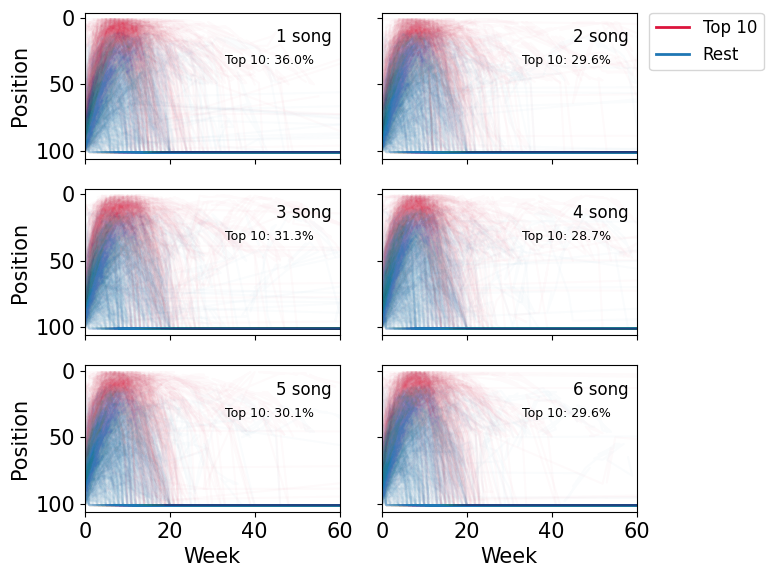

In [178]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)

row_i, col_i = 0, 0

for th_song in range(1, 7):
    hitmakers = numbers_of_songs[numbers_of_songs["number_of_songs"] > 10]["artist"]
    hitmakers_th_song = billboard_hot_100[billboard_hot_100["artist"].isin(hitmakers)][f"{th_song}th_song"]

    hitmakers_th_song_trajectories = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["artist"].isin(hitmakers)) &\
                                                                    billboard_100_with_empty_weeks["song_name"].isin(hitmakers_th_song)][[
        "artist", "song_name", "first_week", "position", "first_day_of_the_week", "top_position"]]
    
    hitmakers_th_song_trajectories["first_day_of_the_week"] = hitmakers_th_song_trajectories.apply(lambda row:
        int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

    hitmakers_th_song_trajectories.set_index("first_day_of_the_week", inplace=True)
    hitmakers_th_song_trajectories_10 = hitmakers_th_song_trajectories[hitmakers_th_song_trajectories["top_position"] <= 10]
    hitmakers_th_song_trajectories_rest = hitmakers_th_song_trajectories[hitmakers_th_song_trajectories["top_position"] > 10]
    
    hitmakers_th_song_trajectories_10.groupby(["artist", "song_name"])["position"].plot(kind="line", ax=axes[row_i, col_i], alpha=0.02,
        color="crimson")
    hitmakers_th_song_trajectories_rest.groupby(["artist", "song_name"])["position"].plot(kind="line", ax=axes[row_i, col_i], alpha=0.02,
        color="C0")
    
    percent_of_top_10 = len(hitmakers_th_song_trajectories_10["song_name"].unique()) / len(hitmakers_th_song_trajectories["song_name"].unique()) * 100
    axes[row_i, col_i].text(0.55, 0.65, f"Top 10: {round(percent_of_top_10, 1)}%", transform=axes[row_i, col_i].transAxes, fontsize=9)
    axes[row_i, col_i].text(0.75, 0.8, f"{th_song} song", transform=axes[row_i, col_i].transAxes, fontsize=12)

    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Week")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Position")
    axes[row_i, col_i].set_xlim([0, 60])

    if row_i == 0 and col_i == 1:
        custom_lines = [Line2D([0], [0], color="crimson", lw=2),
                Line2D([0], [0], color="C0", lw=2)]
        axes[row_i, col_i].legend(custom_lines, ["Top 10", "Rest"], bbox_to_anchor=(1.05, 1),
                        loc='upper left', borderaxespad=0., fontsize=12)

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/hitmakers_1-6th_songs_trajectories.pdf", format="pdf", bbox_inches="tight")
plt.show()

### > 30 songs

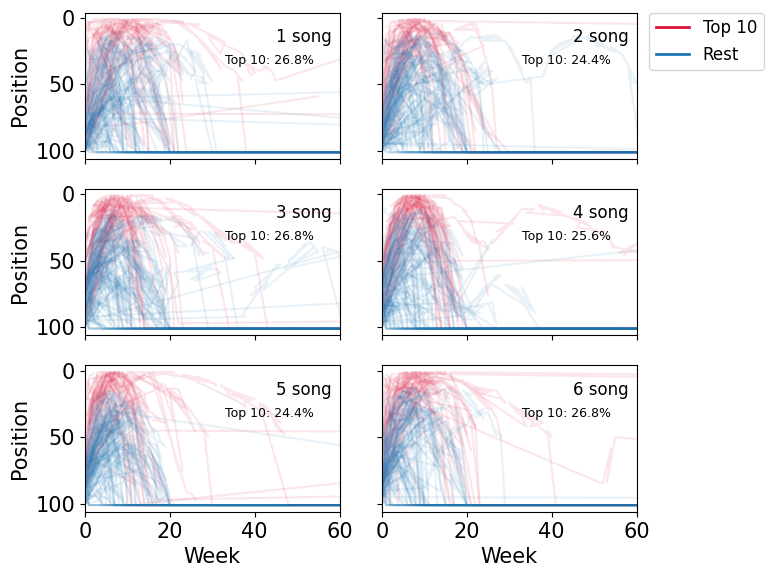

In [188]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)

row_i, col_i = 0, 0

for th_song in range(1, 7):
    hitmakers = numbers_of_songs[numbers_of_songs["number_of_songs"] > 30]["artist"]
    hitmakers_th_song = billboard_hot_100[billboard_hot_100["artist"].isin(hitmakers)][f"{th_song}th_song"]

    hitmakers_th_song_trajectories = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["artist"].isin(hitmakers)) &\
                                                                    billboard_100_with_empty_weeks["song_name"].isin(hitmakers_th_song)][[
        "artist", "song_name", "first_week", "position", "first_day_of_the_week", "top_position"]]
    
    hitmakers_th_song_trajectories["first_day_of_the_week"] = hitmakers_th_song_trajectories.apply(lambda row:
        int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

    hitmakers_th_song_trajectories.set_index("first_day_of_the_week", inplace=True)
    hitmakers_th_song_trajectories_10 = hitmakers_th_song_trajectories[hitmakers_th_song_trajectories["top_position"] <= 10]
    hitmakers_th_song_trajectories_rest = hitmakers_th_song_trajectories[hitmakers_th_song_trajectories["top_position"] > 10]
    
    hitmakers_th_song_trajectories_10.groupby(["artist", "song_name"])["position"].plot(kind="line", ax=axes[row_i, col_i], alpha=0.1,
        color="crimson")
    hitmakers_th_song_trajectories_rest.groupby(["artist", "song_name"])["position"].plot(kind="line", ax=axes[row_i, col_i], alpha=0.1,
        color="C0")
    
    percent_of_top_10 = len(hitmakers_th_song_trajectories_10["song_name"].unique()) / len(hitmakers_th_song_trajectories["song_name"].unique()) * 100
    axes[row_i, col_i].text(0.55, 0.65, f"Top 10: {round(percent_of_top_10, 1)}%", transform=axes[row_i, col_i].transAxes, fontsize=9)
    axes[row_i, col_i].text(0.75, 0.8, f"{th_song} song", transform=axes[row_i, col_i].transAxes, fontsize=12)

    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Week")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Position")
    axes[row_i, col_i].set_xlim([0, 60])

    if row_i == 0 and col_i == 1:
        custom_lines = [Line2D([0], [0], color="crimson", lw=2),
                Line2D([0], [0], color="C0", lw=2)]
        axes[row_i, col_i].legend(custom_lines, ["Top 10", "Rest"], bbox_to_anchor=(1.05, 1),
                        loc='upper left', borderaxespad=0., fontsize=12)

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("figures/hitmakers_1-6th_songs_trajectories_30.pdf", format="pdf", bbox_inches="tight")
plt.show()

### 1-6th song of hitmakers vs. the rest (hitmaker > 10 songs)

In [180]:
def plot_first_x_songs(songs, x, ax, color, alpha_x):
    first_x_songs = [g[1] for g in list(songs.groupby(["artist", "song_name"]))[:x]]
    for song in tqdm(first_x_songs):
        song_series = song["position"]
        ax.plot(song_series.index, song_series.values, alpha=alpha_x, color=color)

In [184]:
def plot_th_song_comparison(hitmaker_number, th_song):
    fig, axes = plt.subplots(2, 2, figsize=(7, 5), sharex=True, sharey=True)

    hitmakers = numbers_of_songs[numbers_of_songs["number_of_songs"] > hitmaker_number]["artist"]
    not_hitmakers = numbers_of_songs[numbers_of_songs["number_of_songs"] <= hitmaker_number]["artist"]
    hitmakers_1_song = billboard_hot_100[billboard_hot_100["artist"].isin(hitmakers)][f"{th_song}th_song"]
    not_hitmakers_1_song = billboard_hot_100[billboard_hot_100["artist"].isin(not_hitmakers)][f"{th_song}th_song"]

    hitmakers_1_song_trajectories = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["artist"].isin(hitmakers)) &\
                                                                    billboard_100_with_empty_weeks["song_name"].isin(hitmakers_1_song)][[
        "artist", "song_name", "first_week", "position", "first_day_of_the_week", "top_position"]]
    hitmakers_1_song_trajectories["first_day_of_the_week"] = hitmakers_1_song_trajectories.apply(lambda row:
        int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

    not_hitmakers_1_song_trajectories = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["artist"].isin(not_hitmakers)) &\
                                                                        billboard_100_with_empty_weeks["song_name"].isin(not_hitmakers_1_song)][[
        "artist", "song_name", "first_week", "position", "first_day_of_the_week", "top_position"]]
    not_hitmakers_1_song_trajectories["first_day_of_the_week"] = not_hitmakers_1_song_trajectories.apply(lambda row:
        int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)


    hitmakers_1_song_trajectories.set_index("first_day_of_the_week", inplace=True)
    not_hitmakers_1_song_trajectories.set_index("first_day_of_the_week", inplace=True)

    hitmakers_1_song_trajectories_10 = hitmakers_1_song_trajectories[hitmakers_1_song_trajectories["top_position"] <= 10]
    hitmakers_1_song_trajectories_rest = hitmakers_1_song_trajectories[hitmakers_1_song_trajectories["top_position"] > 10]
        
    not_hitmakers_1_song_trajectories_10 = not_hitmakers_1_song_trajectories[not_hitmakers_1_song_trajectories["top_position"] <= 10]
    not_hitmakers_1_song_trajectories_rest = not_hitmakers_1_song_trajectories[not_hitmakers_1_song_trajectories["top_position"] > 10]

    no_hitmakers_10_songs = len(hitmakers_1_song_trajectories_10["song_name"].unique())
    no_hitmakers_rest_songs = len(hitmakers_1_song_trajectories_rest["song_name"].unique())

    alpha_x = 0.02 * (hitmaker_number / 10)
    plot_first_x_songs(hitmakers_1_song_trajectories_10, no_hitmakers_10_songs, axes[0, 0], "C0", alpha_x)
    plot_first_x_songs(hitmakers_1_song_trajectories_rest, no_hitmakers_rest_songs, axes[1, 0], "C0", alpha_x)
    plot_first_x_songs(not_hitmakers_1_song_trajectories_10, no_hitmakers_10_songs, axes[0, 1], "C0", alpha_x)
    plot_first_x_songs(not_hitmakers_1_song_trajectories_rest, no_hitmakers_rest_songs, axes[1, 1], "C0", alpha_x)

    # hitmakers_1_song_trajectories_10.groupby(["artist", "song_name"])["position"].plot(kind="line", ax=axes[0, 0], alpha=0.01,
    #     color="C0")
    # hitmakers_1_song_trajectories_rest.groupby(["artist", "song_name"])["position"].plot(kind="line", ax=axes[1, 0], alpha=0.01,
    #     color="C0")
    # not_hitmakers_1_song_trajectories_10.groupby(["artist", "song_name"])["position"].plot(kind="line", ax=axes[0, 1], alpha=0.01,
    #     color="C0") 
    # not_hitmakers_1_song_trajectories_rest.groupby(["artist", "song_name"])["position"].plot(kind="line", ax=axes[1, 1], alpha=0.01,
    #     color="C0")

    axes[0, 0].text(0.55, 0.9, f"Hitmakers", transform=axes[0, 0].transAxes, fontsize=11)
    axes[0, 1].text(0.55, 0.9, f"Not-hitmakers", transform=axes[0, 1].transAxes, fontsize=11)
    axes[0, 0].text(0.55, 0.75, f"Top 10", transform=axes[0, 0].transAxes, fontsize=10)
    axes[0, 1].text(0.55, 0.75, f"Top 10", transform=axes[0, 1].transAxes, fontsize=10)

    axes[1, 0].text(0.55, 0.9, f"Hitmakers", transform=axes[1, 0].transAxes, fontsize=11)
    axes[1, 1].text(0.55, 0.9, f"Not-hitmakers", transform=axes[1, 1].transAxes, fontsize=11)
    axes[1, 0].text(0.55, 0.75, f"Rest", transform=axes[1, 0].transAxes, fontsize=10)
    axes[1, 1].text(0.55, 0.75, f"Rest", transform=axes[1, 1].transAxes, fontsize=10)

    axes[1, 0].set_xlabel("Week")
    axes[1, 1].set_xlabel("Week")
    axes[0, 0].set_ylabel("Position")
    axes[1, 0].set_ylabel("Position")
    axes[0, 0].set_xlim([0, 60])
    axes[0, 1].set_xlim([0, 60])
    axes[1, 0].set_xlim([0, 60])
    axes[1, 1].set_xlim([0, 60])

    # custom_lines = [Line2D([0], [0], color="C0", lw=2),
    #         Line2D([0], [0], color="crimson", lw=2)]
    # axes[1].legend(custom_lines, ["Top 10", "Rest"], bbox_to_anchor=(1.05, 1),
    #                     loc='upper left', borderaxespad=0., fontsize=12)

    fig.tight_layout()
    plt.gca().invert_yaxis()
    plt.savefig(f"figures/{th_song}th_songs_hitmakers_{hitmaker_number}_vs_rest.pdf", format="pdf")
    plt.show()

100%|██████████| 408/408 [00:00<00:00, 1452.81it/s]


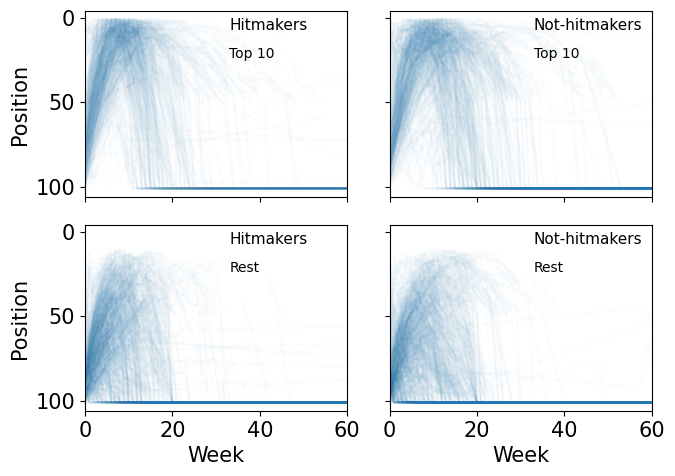

100%|██████████| 428/428 [00:00<00:00, 1313.22it/s]


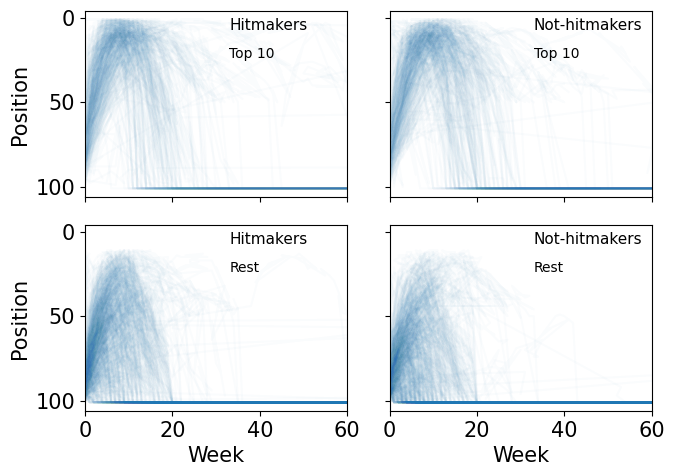

100%|██████████| 410/410 [00:00<00:00, 1209.11it/s]


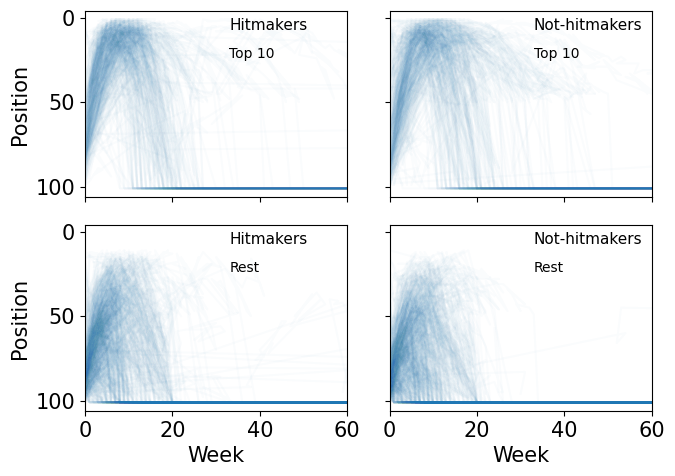

100%|██████████| 432/432 [00:00<00:00, 1689.78it/s]


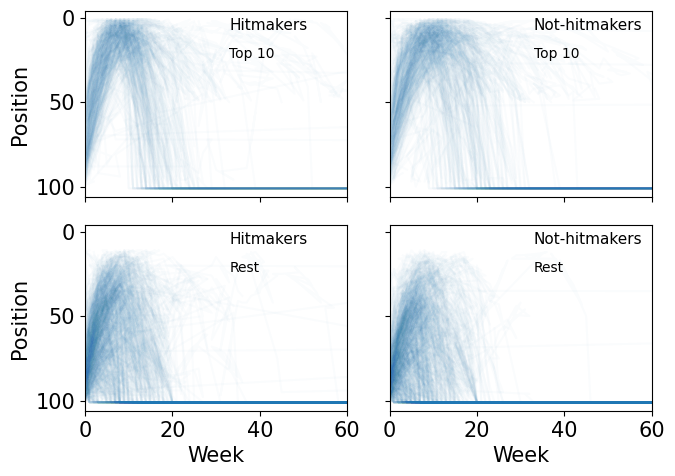

100%|██████████| 420/420 [00:00<00:00, 1776.89it/s]


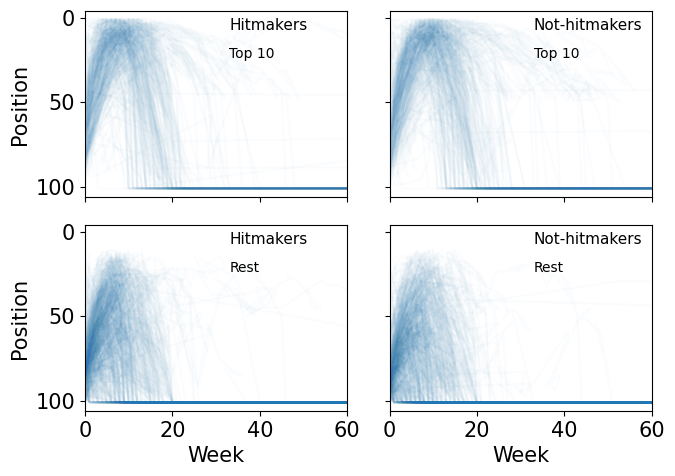

100%|██████████| 428/428 [00:00<00:00, 1666.71it/s]


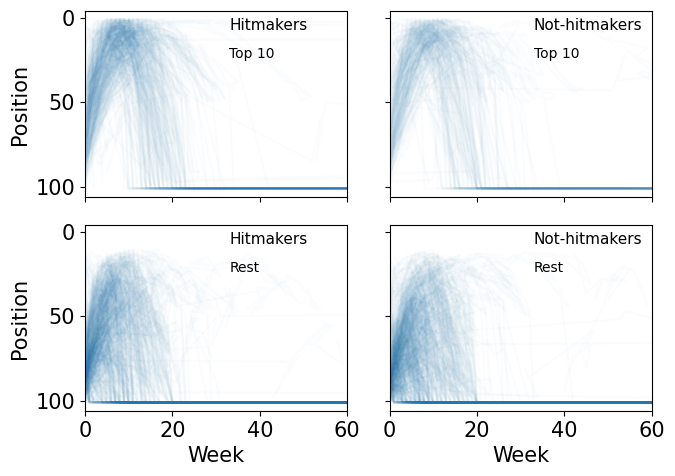

In [185]:
plot_th_song_comparison(10, 1)
plot_th_song_comparison(10, 2)
plot_th_song_comparison(10, 3)
plot_th_song_comparison(10, 4)
plot_th_song_comparison(10, 5)
plot_th_song_comparison(10, 6)

## 1-6th song of hitmaker vs the rest (hitmaker > 30)

100%|██████████| 62/62 [00:00<00:00, 1680.15it/s]


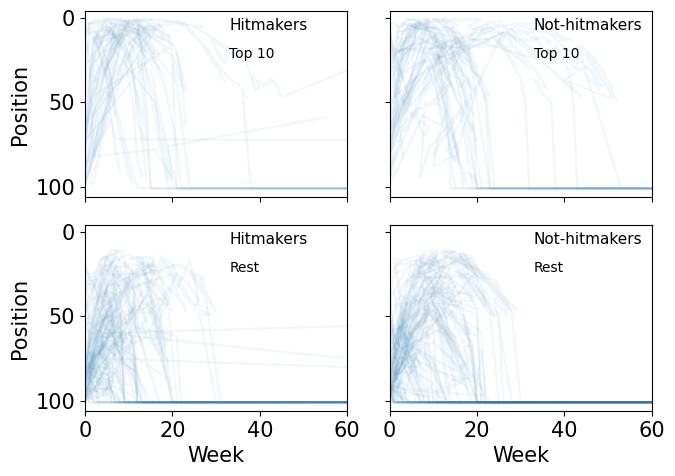

100%|██████████| 66/66 [00:00<00:00, 1378.66it/s]


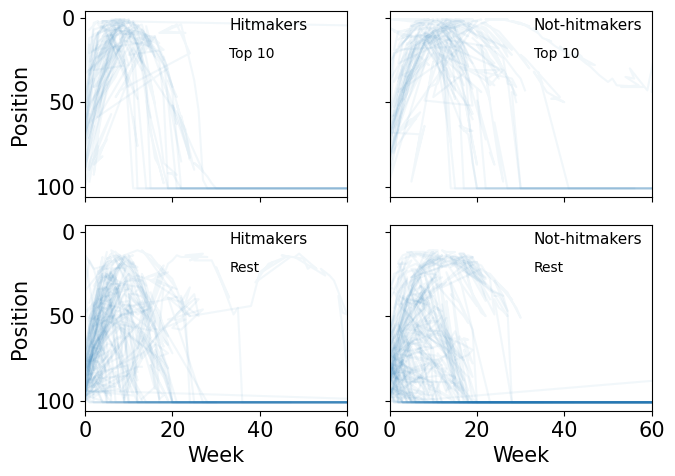

100%|██████████| 62/62 [00:00<00:00, 1053.67it/s]


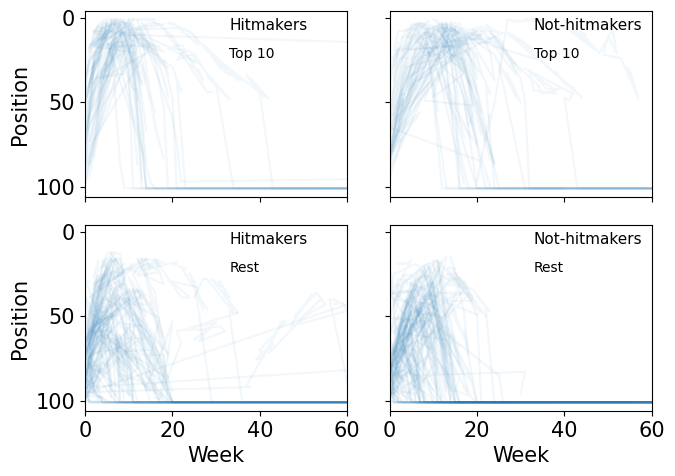

100%|██████████| 64/64 [00:00<00:00, 1309.60it/s]


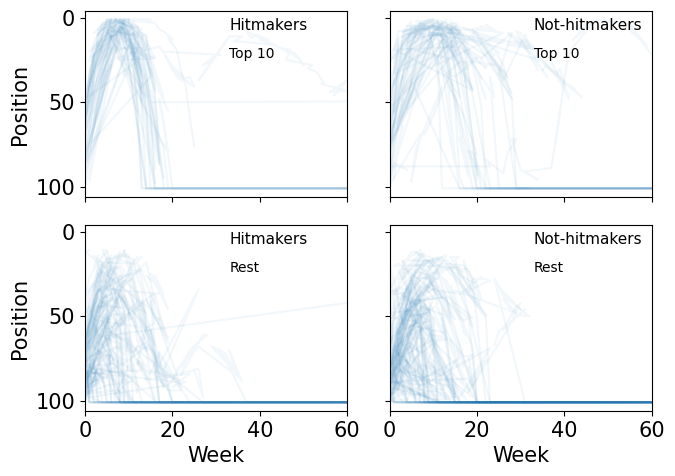

100%|██████████| 65/65 [00:00<00:00, 1550.28it/s]


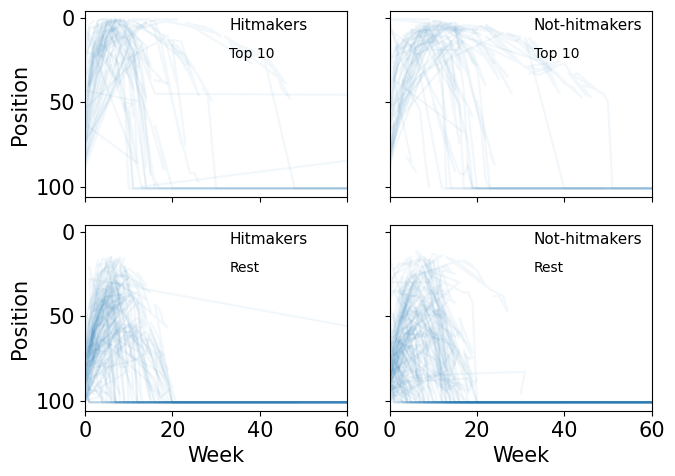

100%|██████████| 65/65 [00:00<00:00, 1589.63it/s]


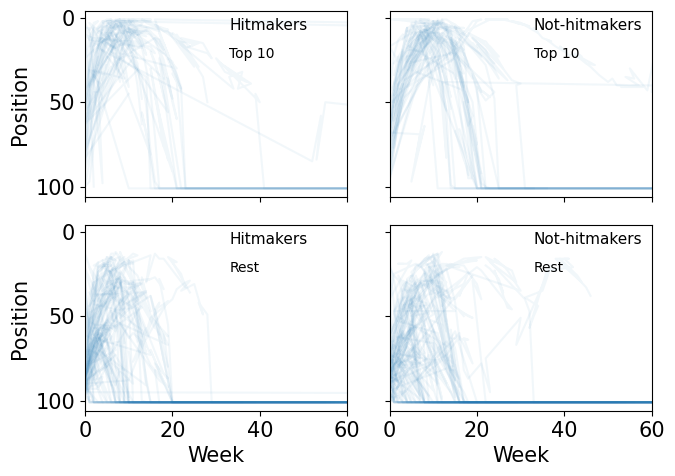

In [186]:
plot_th_song_comparison(30, 1)
plot_th_song_comparison(30, 2)
plot_th_song_comparison(30, 3)
plot_th_song_comparison(30, 4)
plot_th_song_comparison(30, 5)
plot_th_song_comparison(30, 6)

## Hitmakers paths by positions

## Hitmakers paths by decade

## Hitmakers 1-6th songs by decade

## Comparing early carrer with late carrer of artists (1st, 2nd song with last etc)

## Number of songs vs top position of 1st, 2nd... song